In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import numpy as np
from rasterio.plot import show as rasterio_show
from matplotlib_scalebar.scalebar import ScaleBar
from atl_module.utility_functions.plotting import set_size
import cmocean

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

NameError: name 'geopandas' is not defined

# reading the kriging output

In [4]:
def read_kriging_output(site):

    krigingras = rio.open(f"../data/test_sites/{site}/kriging_output.tif")
    print(krigingras.meta)
    # the sigma is the second band
    uncertainty = krigingras.read(2, masked=True).filled(np.NaN)
    # the actual bathymetry estimate is the first band
    kriged_bathy = krigingras.read(1, masked=True).filled(np.NaN)
    height = uncertainty.shape[0]
    width = uncertainty.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(krigingras.transform, rows, cols)
    eastings = np.array(xs)
    northings = np.array(ys)

    return uncertainty, kriged_bathy, eastings, northings, krigingras

# making the 3d figure

In [5]:
# %matplotlib widget

In [48]:
def plot3d(
    site,
    subset_pts,
    uncertainty,
    kriged_bathy,
    northings,
    eastings,
    utm_name,
    title,
    azim,
    elev,
):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    # set the view, the best view depends on the site so requires experimentation
    ax.view_init(elev=elev, azim=azim)
    ax.scatter3D(
        subset_pts.X,
        subset_pts.Y,
        subset_pts.Z,
        s=3,
        label="ICESat-2 points",
    )
    ax.set_title(title)
    # set the labels as needed
    ax.set_zlabel("Elevation [m +MSL]")
    ax.set_xlabel(f"Easting [m {utm_name}]")
    ax.set_ylabel(f"Northing [m {utm_name}]")
    fig.tight_layout()

    fig.savefig(
        f"../data/gl_pres_data/for_powerpoint/{site}_3d_points_only.png",
        bbox_inches="tight",
    )
    ax.plot_wireframe(
        eastings,
        northings,
        kriged_bathy,
        color="red",
        alpha=0.5,
        label="Kriging surface",
    )

    # find the location of the bottom of the plot based on the minimum depth of the bathymetry points:
    mindepth = min(subset_pts.Z.min(), kriged_bathy.min())
    xmin = min(subset_pts.X.min(), eastings.min())
    xmax = max(subset_pts.X.max(), eastings.max())
    ymin = min(subset_pts.Y.min(), northings.min())
    ymax = max(subset_pts.Y.max(), northings.max())
    contourf_artist = ax.contourf(
        eastings, northings, uncertainty, 100, offset=mindepth, zdir="z", cmap="plasma"
    )

    # set plot limits
    ax.set_zlim3d(
        top=0,
        bottom=mindepth,
    )
    # ax.set_xlim3d(left=xmin,right=xmax)
    ax.set_ylim3d(top=ymax, bottom=ymin)
    # ax.set_aspect(1.5)

    ax.legend()
    fig.colorbar(
        contourf_artist,
        ax=ax,
        label="Variance [m$^2$]",
        orientation="vertical",
        fraction=0.025,
        location="left",
        pad=0.01,
    )

    fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")
    fig.savefig(
        f"../data/gl_pres_data/for_powerpoint/{site}_plot_3d.png", bbox_inches="tight"
    )

In [49]:
def plot_kriging_output(
    site,
    kriging_raster_dataset: rio.DatasetReader,
    kriging_pt_df: gpd.GeoDataFrame,
    uncertainty,
    kriged_bathy,
    title,
    horiz=True,
):
    ncols = 1
    nrows = 2
    figsize = set_size(fraction=1, ratio=1.68 / 1.5)

    minx, miny, maxx, maxy = kriging_pt_df.geometry.total_bounds
    data_scale_hv = (maxx - minx) / (maxy - miny)
    # figsize = set_size(ratio=)
    if horiz:
        nrows = 1
        ncols = 2
        # figsize = set_size(fraction=1, ratio=1.68 * 2)

    # set up the figure with two subplots
    fig, (ax2, ax1) = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # get the artists of the imageshow function for later, then clear the axes
    imartist_sigma = ax1.imshow(uncertainty, cmap="plasma")
    ax1.clear()
    imartist_elevation_surface = ax2.imshow(kriged_bathy, cmap=cmocean.cm.deep_r)
    ax2.clear()
    scalebar = ScaleBar(1, units="m", location="lower right")
    ax2.add_artist(scalebar)

    # plot the points on both axes
    kriging_pt_df.plot(ax=ax1, c="black", markersize=2, label="ICESat-2 Point")
    kriging_pt_df.plot(ax=ax2, c="black", markersize=2)

    # open the zero contour line and project it to the local UTM
    # zero_contour = gpd.read_file(f"../data/test_sites/{site}/in-situ-DEM/contour.shp").to_crs(kriging_pt_df.crs)
    # zero_contour.plot(ax=ax1,)
    # zero_contour.plot(ax=ax2,)

    # plot the image with geo unit axes
    rasterio_show((kriging_raster_dataset, 2), ax=ax1, cmap="plasma")
    rasterio_show((kriging_raster_dataset, 1), ax=ax2, cmap=cmocean.cm.deep_r)

    # add the colormaps using the artists we got before
    orientval = "horizontal"
    fig.colorbar(
        imartist_sigma,
        ax=ax1,
        label="Variance [m$^2$]",
        orientation=orientval,
        pad=0.05,
    )
    fig.colorbar(
        imartist_elevation_surface,
        ax=ax2,
        label="Interpolated Elevation [m +MSL]",
        orientation=orientval,
        pad=0.05,
    )
    fig.tight_layout()
    # ax1.legend(bbo)
    # fig.legend()
    # ax1.legend(bbox_to_anchor=[-0.1,1.2])
    # return fig
    # fig.suptitle(title)

    fig.savefig(f"../data/gl_pres_data/{site}_kriging_output.pdf", bbox_inches="tight")
    fig.savefig(
        f"../data/gl_pres_data/for_powerpoint/{site}_kriging_output.png",
        bbox_inches="tight",
    )

In [50]:
def both_kriging_plots(site, azim, elev, horiz, title):
    # get a dataframe of all bathymetry points
    all_df = gpd.read_file(f"../data/test_sites/{site}/all_bathy_pts.gpkg")
    #  get a dataframe of the subsampled points
    subset_df = gpd.read_file(f"../data/test_sites/{site}/kriging_pts/")
    # find the name of the UTM grid
    utm_name = subset_df.crs.name.strip("WGS 84 / ")
    # convert to a numpy array
    subset_pts = subset_df.drop(columns="geometry").to_records(index=False)

    # get the kriging data
    uncertainty, kriged_bathy, eastings, northings, dataset = read_kriging_output(site)
    # plot and save the 3d plot
    plot3d(
        site,
        subset_pts,
        uncertainty,
        kriged_bathy,
        northings,
        eastings,
        utm_name,
        title=title,
        azim=azim,
        elev=elev,
    )
    # plot and save the kriged output and uncertainty
    plot_kriging_output(
        site=site,
        kriging_raster_dataset=dataset,
        kriging_pt_df=subset_df,
        uncertainty=uncertainty,
        kriged_bathy=kriged_bathy,
        horiz=horiz,
        title=title,
    )

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 573, 'height': 178, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(60.0, 0.0, 592142.5164024365,
       0.0, -60.0, 2359504.4994517276)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


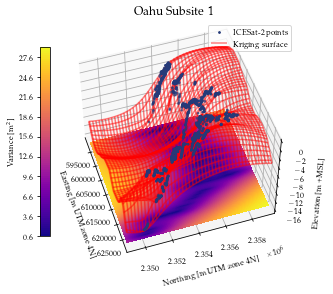

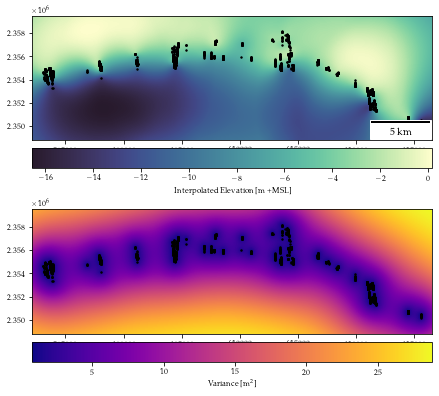

In [51]:
both_kriging_plots("oahu1", azim=-18, elev=50, horiz=False, title="Oahu Subsite 1")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 698, 'height': 638, 'count': 2, 'crs': CRS.from_epsg(32617), 'transform': Affine(50.0, 0.0, 481042.64972345135,
       0.0, -50.0, 2752610.2761525554)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


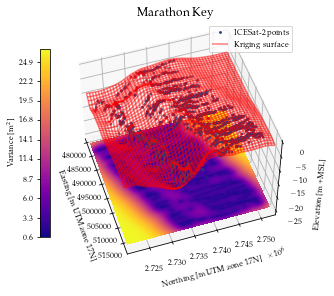

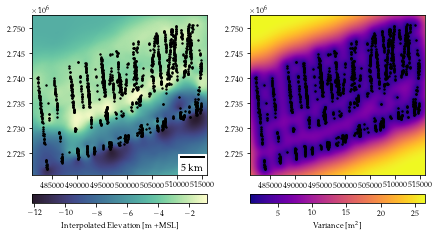

In [52]:
both_kriging_plots("florida_keys", azim=-18, elev=50, horiz=True, title="Marathon Key")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 734, 'height': 268, 'count': 2, 'crs': CRS.from_epsg(32620), 'transform': Affine(60.0, 0.0, 281113.87581913185,
       0.0, -60.0, 2037141.6320268328)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


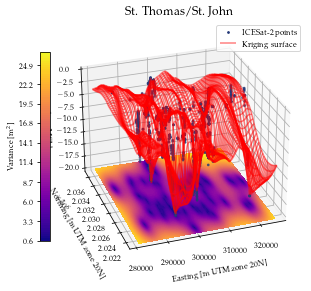

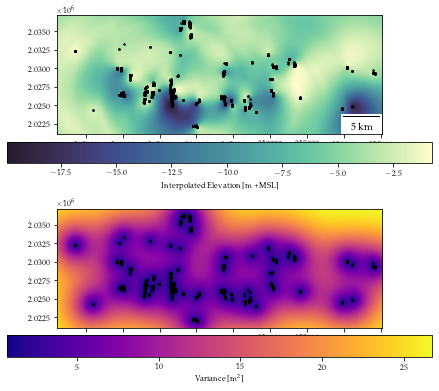

In [53]:
both_kriging_plots(
    "charlotteamalie", azim=-109, elev=28, horiz=False, title="St. Thomas/St. John"
)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 378, 'height': 198, 'count': 2, 'crs': CRS.from_epsg(32620), 'transform': Affine(100.0, 0.0, 296581.26483105076,
       0.0, -100.0, 1970259.2944738078)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


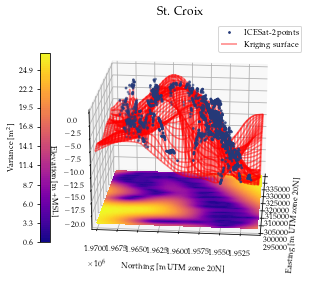

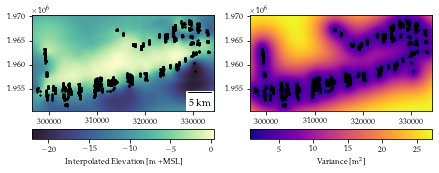

In [54]:
both_kriging_plots("stcroix", azim=-175, elev=20, horiz=True, title="St. Croix")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 271, 'height': 127, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(60.0, 0.0, 624556.0534920761,
       0.0, -60.0, 2356648.202023852)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


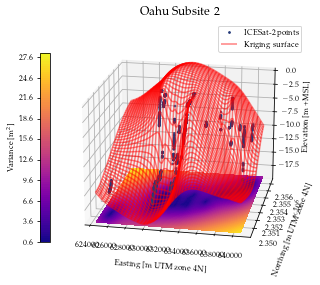

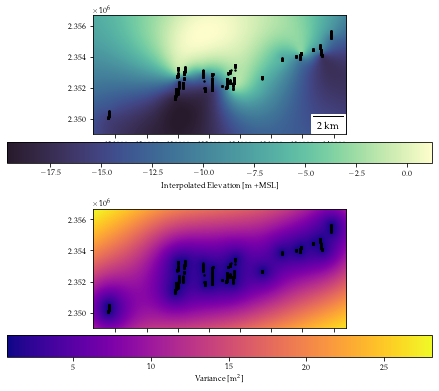

In [55]:
both_kriging_plots("oahu2", azim=-79, elev=19, horiz=False, title="Oahu Subsite 2")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 104, 'height': 189, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(100.0, 0.0, 630509.9741142658,
       0.0, -100.0, 2375510.2887973427)}


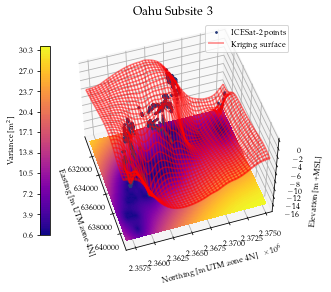

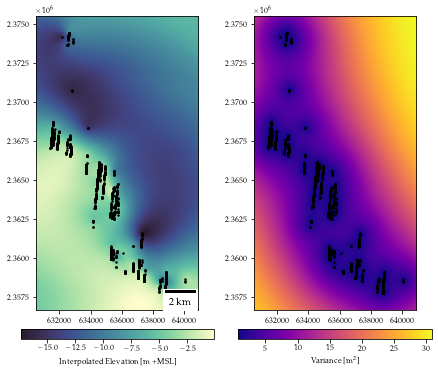

In [56]:
both_kriging_plots("oahu3", azim=-18, elev=50, horiz=True, title="Oahu Subsite 3")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 196, 'height': 221, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(100.0, 0.0, 614192.7579734544,
       0.0, -100.0, 2389231.28000759)}


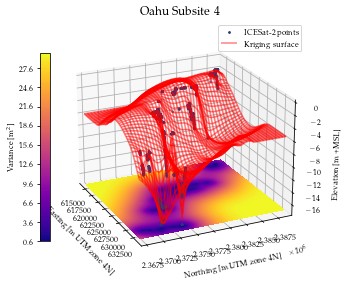

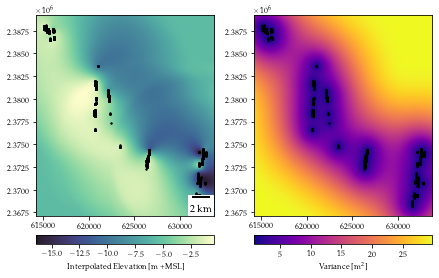

In [57]:
both_kriging_plots("oahu4", azim=-25, elev=22, horiz=True, title="Oahu Subsite 4")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 117, 'height': 171, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(100.0, 0.0, 605389.1486283186,
       0.0, -100.0, 2402525.7452704785)}


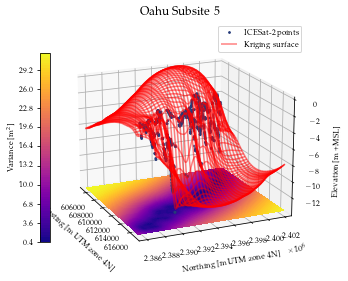

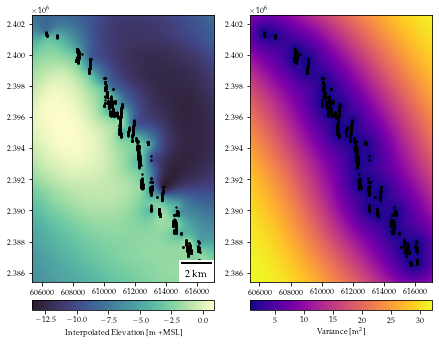

In [58]:
both_kriging_plots("oahu5", azim=-24, elev=18, horiz=True, title="Oahu Subsite 5")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 148, 'height': 128, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(100.0, 0.0, 593194.9482933193,
       0.0, -100.0, 2402461.9937390652)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


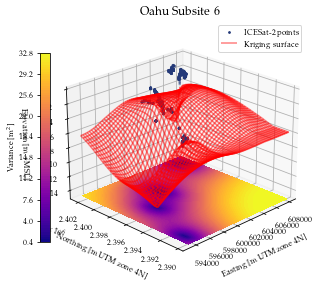

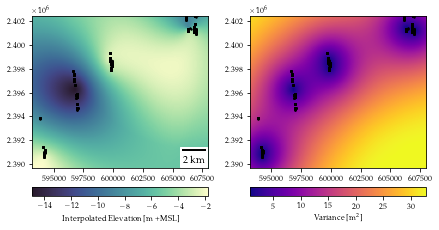

In [59]:
both_kriging_plots("oahu6", azim=-135, elev=23, horiz=True, title="Oahu Subsite 6")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 110, 'height': 36, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(100.0, 0.0, 579098.7232922617,
       0.0, -100.0, 2389086.3540206784)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


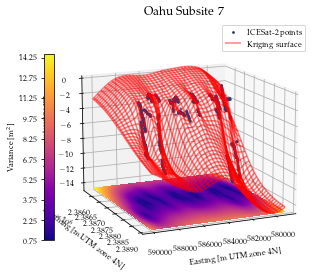

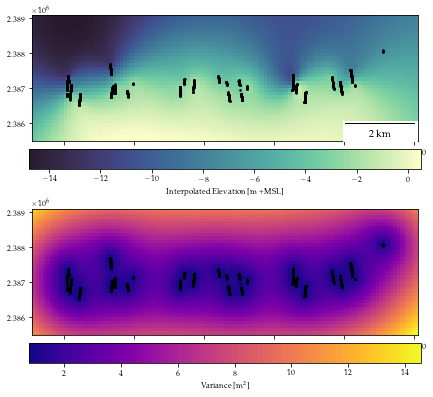

In [60]:
both_kriging_plots("oahu7", azim=66, elev=14, horiz=False, title="Oahu Subsite 7")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 365, 'height': 656, 'count': 2, 'crs': CRS.from_epsg(32604), 'transform': Affine(50.0, 0.0, 574353.3740589365,
       0.0, -50.0, 2386138.116122889)}


/tmp/ipykernel_24890/2044835140.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")


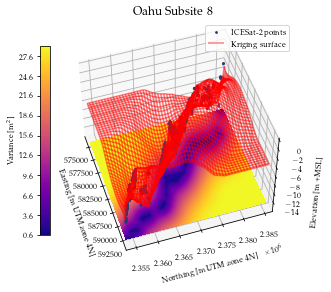

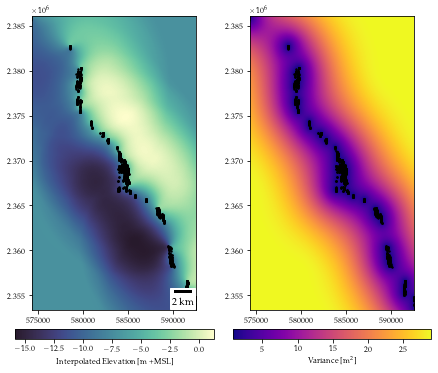

In [61]:
both_kriging_plots("oahu8", azim=-18, elev=50, horiz=True, title="Oahu Subsite 8")